In [8]:
import tensorflow as tf
import os
import numpy as np
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [9]:
# Paths
input_dir = '/kaggle/input/brain-ct-sinograms-64-augmented-2-0/Datasets/brain_CT_sinograms_64_augmented'
output_dir = '/kaggle/input/brain-ct-sinograms-64-augmented-2-0/Datasets/brain_CT_64_augmented'

# Get sorted file names (to ensure matching)
input_files = sorted(os.listdir(input_dir))
output_files = sorted(os.listdir(output_dir))


In [10]:
# Initialize lists
x_data = []
y_data = []

# Load images
for in_file, out_file in zip(input_files, output_files):
    # Load grayscale image and resize to (256, 256)
    input_img = load_img(os.path.join(input_dir, in_file), color_mode='grayscale', target_size=(91,64))
    output_img = load_img(os.path.join(output_dir, out_file), color_mode='grayscale', target_size=(64, 64))
    
    # Convert to array and normalize to [0, 1]
    x = img_to_array(input_img) / 255.0
    y = img_to_array(output_img) / 255.0

    x_data.append(x)
    y_data.append(y)

# Convert to NumPy arrays
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

print("Input shape:", x_data.shape)   # (125, 256, 256, 1)
print("Output shape:", y_data.shape)  # (125, 256, 256, 1)

Input shape: (2500, 91, 64, 1)
Output shape: (2500, 64, 64, 1)


In [11]:
x_train = x_data[:2000]
x_test = x_data[2000:]
y_train = y_data[:2000]
y_test = y_data[2000:]

In [12]:
print(x_train.shape)
print(y_train.shape)

(2000, 91, 64, 1)
(2000, 64, 64, 1)


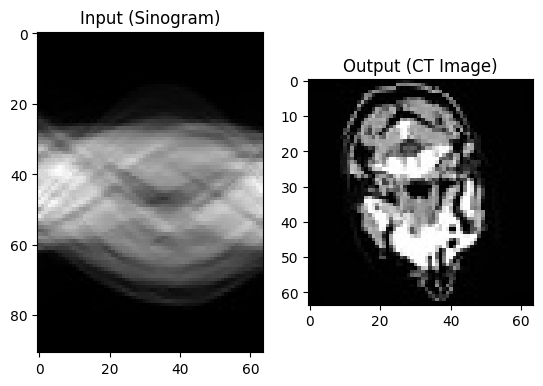

In [13]:
index = 4

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(x_data[index].squeeze(), cmap='gray')
plt.title('Input (Sinogram)')

plt.subplot(1, 2, 2)
plt.imshow(y_data[index].squeeze(), cmap='gray')
plt.title('Output (CT Image)')
plt.show()

# Model

In [14]:
import tensorflow as tf
from tensorflow.keras.metrics import Mean

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [15]:
from tensorflow.keras import models, layers

def build_automap(input_shape=(91, 64, 1), dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    # Flatten the input
    x = layers.Flatten()(inputs)

    # Fully connected layers
    x = layers.Dense(91 * 64, activation='relu')(x)
    x = layers.Dense(64 * 64, activation='sigmoid')(x)  # sigmoid to keep output in [0,1]

    # Reshape to image
    outputs = layers.Reshape((64, 64, 1))(x)

    return models.Model(inputs, outputs)


In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=40, restore_best_weights=True)

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
model = build_automap()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError(), metrics=[psnr_metric, ssim_metric])

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 91, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5824)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5824)                │      33,924,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      23,859,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,784,000 (220.43 MB)

 Trainable params: 57,784,000 (220.43 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# # Training
# history = model.fit(
#     x_train, y_train,
#     validation_data=(x_test, y_test),
#     batch_size=10,
#     epochs= ,
#     verbose=1
# )

In [25]:
import matplotlib.pyplot as plt

# Assuming you already have:
# model = build_automap(...)
# and your data: x_train, y_train, x_val, y_val

history = model.fit(
    x_train, y_train,
    epochs=300,
    batch_size=8,
    validation_data=(x_test, y_test),
    callbacks = [early_stop]
)



Epoch 1/300


W0000 00:00:1751432430.005015     129 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1751432430.005109     129 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0623 - psnr_metric: 12.5854 - ssim_metric: 0.2012 - val_loss: 0.0334 - val_psnr_metric: 14.8982 - val_ssim_metric: 0.2791
Epoch 2/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0341 - psnr_metric: 14.8579 - ssim_metric: 0.3080 - val_loss: 0.0289 - val_psnr_metric: 15.6059 - val_ssim_metric: 0.3881
Epoch 3/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0291 - psnr_metric: 15.5938 - ssim_metric: 0.3959 - val_loss: 0.0273 - val_psnr_metric: 15.8602 - val_ssim_metric: 0.4377
Epoch 4/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0267 - psnr_metric: 15.9990 - ssim_metric: 0.4466 - val_loss: 0.0261 - val_psnr_metric: 16.0907 - val_ssim_metric: 0.4558
Epoch 5/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0248 - psnr_metric: 16.3305 - ssim_metric: 0.4753 - val_loss: 0.0250 - val_psnr_metric: 16.3015 - val_ssim_metric: 0.4809
Epoch 6/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0226 - psnr_metric: 16.

In [36]:
history.history.keys()


dict_keys(['loss', 'psnr_metric', 'ssim_metric', 'val_loss', 'val_psnr_metric', 'val_ssim_metric'])

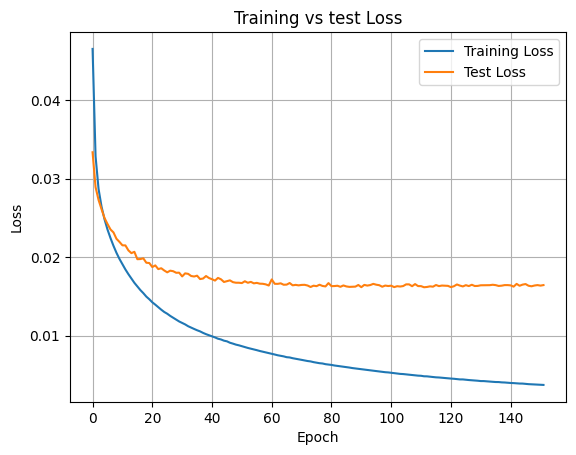

In [26]:
# Plot Training vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs test Loss')
plt.legend()
plt.grid(True)
plt.show()



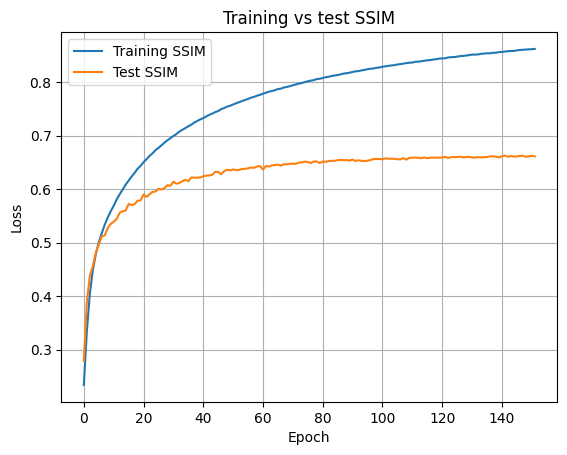

In [27]:
# Plot Training vs Validation Loss
plt.plot(history.history['ssim_metric'], label='Training SSIM')
plt.plot(history.history['val_ssim_metric'], label='Test SSIM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs test SSIM')
plt.legend()
plt.grid(True)
plt.show()


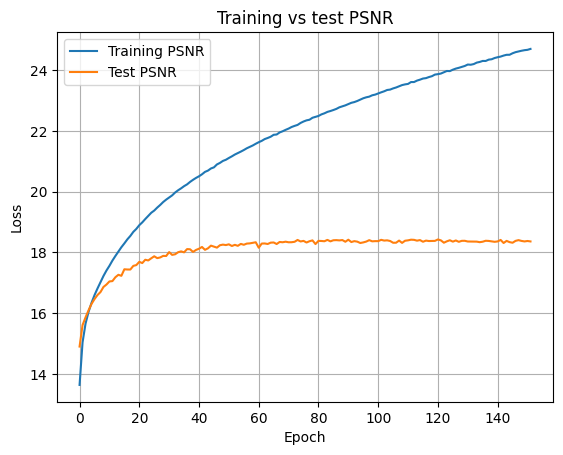

In [28]:
# Plot Training vs Validation Loss
plt.plot(history.history['psnr_metric'], label='Training PSNR')
plt.plot(history.history['val_psnr_metric'], label='Test PSNR')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs test PSNR')
plt.legend()
plt.grid(True)
plt.show()


## Evaluation by Plotting Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


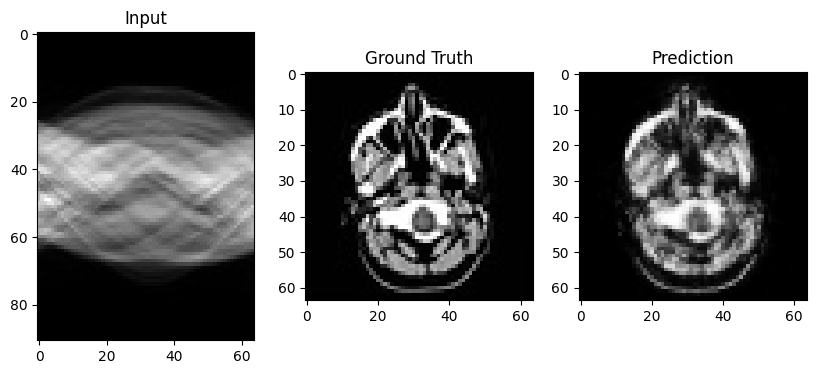

In [29]:
import matplotlib.pyplot as plt

i = 50# index of sample
pred = model.predict(x_train[i:i+1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(x_train[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_train[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='gray')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


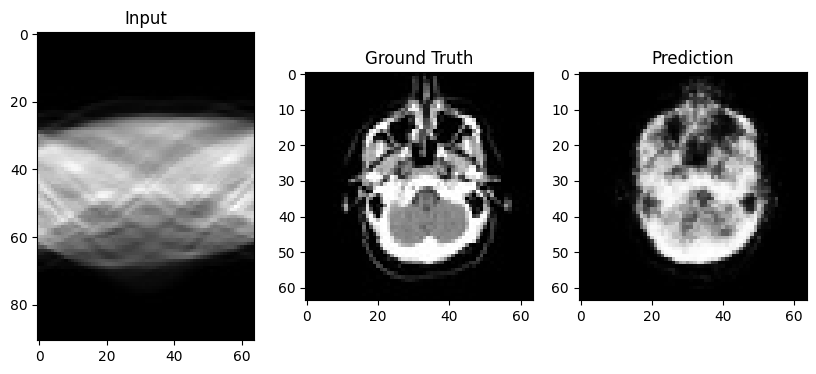

In [30]:
import matplotlib.pyplot as plt

i = 50# index of sample
pred = model.predict(x_test[i:i+1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(x_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='gray')
plt.show()


## Evaluate using PSNR and SSIM

In [ ]:
import tensorflow as tf
import numpy as np

total_psnr = 0.0
total_ssim = 0.0
n = len(x_test)

for i in range(n):
    pred = model.predict(x_test[i:i+1], verbose=0)  # shape: (1, 256, 256, 1)
    gt = y_test[i:i+1]

    # Compute PSNR and SSIM
    psnr_val = tf.image.psnr(gt, pred, max_val=1.0).numpy()[0]
    ssim_val = tf.image.ssim(gt, pred, max_val=1.0).numpy()[0]

    total_psnr += psnr_val
    total_ssim += ssim_val

# Average metrics
avg_psnr = total_psnr / n
avg_ssim = total_ssim / n

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")


In [20]:
import tensorflow as tf
import numpy as np

total_psnr = 0.0
total_ssim = 0.0
n = len(x_test)

for i in range(n):
    pred = model.predict(x_train[i:i+1], verbose=0)  # shape: (1, 256, 256, 1)
    gt = y_train[i:i+1]

    # Compute PSNR and SSIM
    psnr_val = tf.image.psnr(gt, pred, max_val=1.0).numpy()[0]
    ssim_val = tf.image.ssim(gt, pred, max_val=1.0).numpy()[0]

    total_psnr += psnr_val
    total_ssim += ssim_val

# Average metrics
avg_psnr = total_psnr / n
avg_ssim = total_ssim / n

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")


Average PSNR: 21.81 dB
Average SSIM: 0.7971


In [32]:
model.save('automap_model_dense_300epoch.h5')